In [2]:
# Analysis of Experimental Mouse Brain Data Courtesy of Marija. 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load .mat file containing the Time series data.  Is a 169 x 900 x 100 Matrix.  Num brian regions x Num samples recorinding x num mice
# https://towardsdatascience.com/how-to-load-matlab-mat-files-in-python-1f200e1287b5 
from scipy.io import loadmat
annots = loadmat('E:\Documents\Work\\Year 5 Sem 1 - 2020\\timeSeriesData.mat') 
DataMatrix = annots['timeSeriesData']

'''
# Import StructInfo - Gives error for now, likely due to depracation of Python 2
StructInfo = pd.read_excel (r'E:\Documents\Work\structInfo_Oh_169.xlsx')
'''
# Verify shape.
DataMatrix.shape

(169L, 900L, 100L)

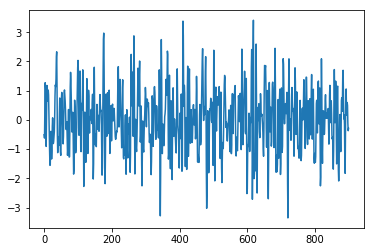

In [9]:
# Have a Look at Region 38, Mouse 0
plt.plot(DataMatrix[37,:,0])

In [98]:
# What needs to happen is to obtain each matrix (100 total for the no. of mice)

# Create empty 3D Matrix to hold FC analysis
FCMatrix = np.empty((38,38,100))

for i in range(100):
    # For now we only take the cortical areas, so the first 38 rows.
    run = DataMatrix[0:38,:,i]

    # np.size(DataMatrix[:,:,0]) # Verify correct. 

    # Run Analysis - Pearson Correlation.
    FCM = np.corrcoef(run)
    FCMatrix[:,:,i] = FCM

# Average over the 100 mice. 
FCAverage = FCMatrix.mean(2)

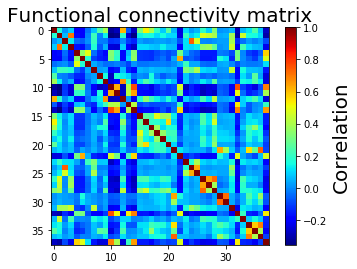

In [100]:
# Plot Matrix
# For Individual slice of FC Matrix: FCMatrix[:,:,0]

cs=plt.imshow(FCAverage, cmap='jet', aspect='equal', interpolation='none')
plt.title('Functional connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Correlation', fontsize=20)

In [101]:
# Write Code to export the simulation to csv.
np.savetxt("do-not-track\FCM_MouseExperimental.csv", FCAverage, delimiter=",")

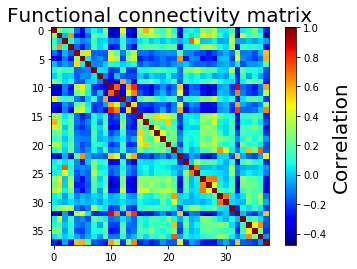

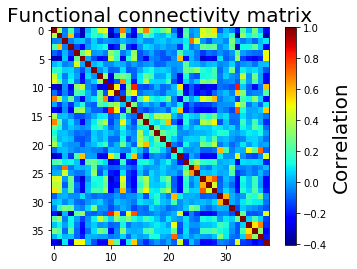

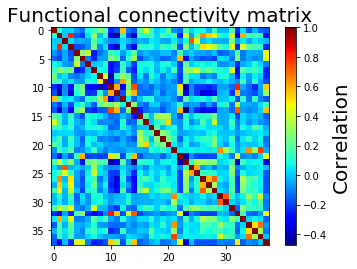

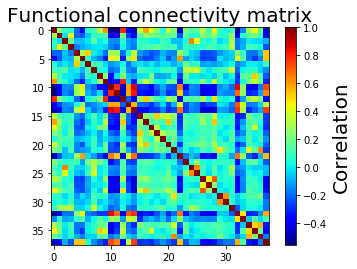

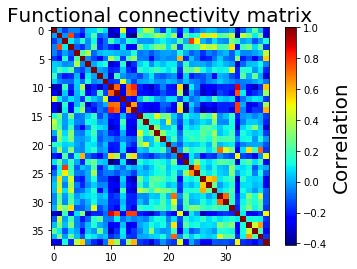

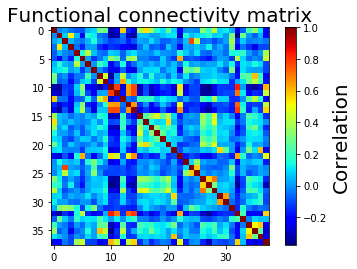

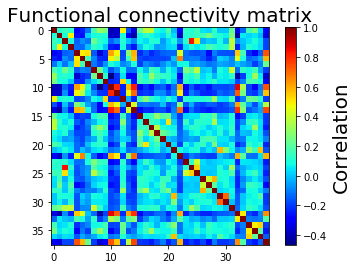

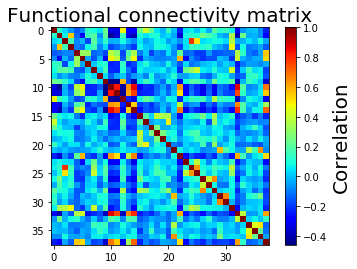

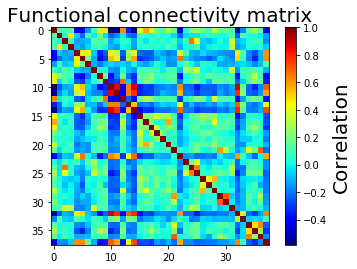

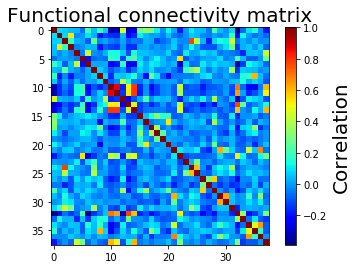

In [114]:
# Plot the FC Matrices for Each mouse as a check. 

for i in range(10):
    plt.figure()
    cs=plt.imshow(FCMatrix[:,:,i], cmap='jet', aspect='equal', interpolation='none')
    plt.title('Functional connectivity matrix', fontsize=20)
    axcb=plt.colorbar(cs)
    axcb.set_label('Correlation', fontsize=20)# Sanity s\check seems good.